In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     #transforms.Resize((28, 28)),
                                     transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                     #transforms.RandomRotation((-7.0, 7.0)),
                                     #transforms.RandomGrayscale(p=0.01),        
                                     #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/home/rogbot/deepvision/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=16, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
import torch.nn.functional as F
dropout_value = 0.01

class NetLN(nn.Module):
    def __init__(self):
        super(NetLN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([11, 26, 26]),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([19, 24, 24]),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.LayerNorm([10, 24, 24]),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 10, 10]),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 8, 8]),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 6, 6]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 6, 6]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

       
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
modelLN = NetLN().to(device)
summary(modelLN, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
         LayerNorm-3           [-1, 11, 26, 26]          14,872
           Dropout-4           [-1, 11, 26, 26]               0
            Conv2d-5           [-1, 19, 24, 24]           1,881
              ReLU-6           [-1, 19, 24, 24]               0
         LayerNorm-7           [-1, 19, 24, 24]          21,888
           Dropout-8           [-1, 19, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             190
        LayerNorm-10           [-1, 10, 24, 24]          11,520
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 15, 10, 10]           1,350
             ReLU-13           [-1, 15, 10, 10]               0
        LayerNorm-14           [-1

In [7]:
import torch.nn.functional as F
dropout_value = 0.01

class NetGN(nn.Module):
    def __init__(self):
        super(NetGN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(11),
            nn.GroupNorm(1, 11),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(19),
            nn.GroupNorm(1, 19),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.GroupNorm(5, 10),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

       
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [8]:
modelGN = NetGN().to(device)
summary(modelGN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
         GroupNorm-3           [-1, 11, 26, 26]              22
           Dropout-4           [-1, 11, 26, 26]               0
            Conv2d-5           [-1, 19, 24, 24]           1,881
              ReLU-6           [-1, 19, 24, 24]               0
         GroupNorm-7           [-1, 19, 24, 24]              38
           Dropout-8           [-1, 19, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             190
        GroupNorm-10           [-1, 10, 24, 24]              20
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 15, 10, 10]           1,350
             ReLU-13           [-1, 15, 10, 10]               0
        GroupNorm-14           [-1, 15,

In [9]:
import torch.nn.functional as F
dropout_value = 0.01

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(11),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(19),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
       
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [10]:
modelBNL1 = Net().to(device)
summary(modelBNL1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
       BatchNorm2d-3           [-1, 11, 26, 26]              22
            Conv2d-4           [-1, 19, 24, 24]           1,881
              ReLU-5           [-1, 19, 24, 24]               0
       BatchNorm2d-6           [-1, 19, 24, 24]              38
            Conv2d-7           [-1, 10, 24, 24]             190
       BatchNorm2d-8           [-1, 10, 24, 24]              20
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 15, 10, 10]           1,350
             ReLU-11           [-1, 15, 10, 10]               0
      BatchNorm2d-12           [-1, 15, 10, 10]              30
          Dropout-13           [-1, 15, 10, 10]               0
           Conv2d-14             [-1, 1

In [11]:
from tqdm import tqdm

train_lossesLN = []
test_lossesLN = []
train_accLN = []
test_accLN = []

def trainLN(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_lossesLN.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accLN.append(100*correct/processed)

def testLN(model, device, test_loader):
    model.eval()
    test_lossLN = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_lossLN += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_lossLN /= len(test_loader.dataset)
    test_lossesLN.append(test_lossLN)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_lossLN, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_accLN.append(100. * correct / len(test_loader.dataset))

In [12]:
train_lossesGN = []
test_lossesGN = []
train_accGN = []
test_accGN = []

def trainGN(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_lossesGN.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accGN.append(100*correct/processed)

def testGN(model, device, test_loader):
    model.eval()
    test_lossGN = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_lossGN += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_lossGN /= len(test_loader.dataset)
    test_lossesGN.append(test_lossGN)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_lossGN, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_accGN.append(100. * correct / len(test_loader.dataset))

In [13]:
from tqdm import tqdm
from torch.autograd import Variable

train_lossesBNL1 = []
test_lossesBNL1 = []
train_accBNL1 = []
test_accBNL1 = []

lambda_ = 0.0005

def trainBNL1(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # L1 regularization  
    #L1_norm = Variable( torch.FloatTensor(1), requires_grad=True)
    #L1_norm = sum(w.abs().sum() for w in model.parameters())
    #loss += lambda_ * L1_norm
    
    l1_reg = None
    for w in model.parameters():
        if l1_reg is None:
            l1_reg = w.abs().sum()
        else:
            l1_reg = l1_reg + w.abs().sum()
            
    loss += lambda_*l1_reg
   
    train_lossesBNL1.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accBNL1.append(100*correct/processed)

def testBNL1(model, device, test_loader):
    model.eval()
    test_lossBNL1 = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_lossBNL1 += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_lossBNL1 /= len(test_loader.dataset)
    test_lossesBNL1.append(test_lossBNL1)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_lossBNL1, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_accBNL1.append(100. * correct / len(test_loader.dataset))

In [14]:
from torch.optim.lr_scheduler import StepLR

modelLN =  NetLN().to(device)
modelGN =  NetGN().to(device)
modelBNL1 = Net().to(device)

optimizerLN = optim.SGD(modelLN.parameters(), lr=0.01, momentum=0.9)
optimizerGN = optim.SGD(modelGN.parameters(), lr=0.01, momentum=0.9)
optimizerBNL1 = optim.SGD(modelBNL1.parameters(), lr=0.01, momentum=0.9)


#schedulerLN = StepLR(optimizerLN, step_size=6, gamma=0.00001)
#schedulerGN = StepLR(optimizerGN, step_size=6, gamma=0.00001)
#schedulerBNL1 = StepLR(optimizerBNL1, step_size=6, gamma=0.00001)


#learning_rate = 0.01
#optimizerLN = torch.optim.Adam(modelLN.parameters(), lr=learning_rate)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.0001)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    trainLN(modelLN, device, train_loader, optimizerLN, epoch)
    trainGN(modelGN, device, train_loader, optimizerGN, epoch)
    trainBNL1(modelBNL1, device, train_loader, optimizerBNL1, epoch)
    
    #schedulerLN.step()
    #schedulerGN.step()
    #schedulerBNL1.step()

    testLN(modelLN, device, test_loader)
    testGN(modelGN, device, test_loader)
    testBNL1(modelBNL1, device, test_loader)

EPOCH: 0


Loss=0.15275299549102783 Batch_id=937 Accuracy=94.13: 100%|█| 938/938 [00:09<00:
Loss=0.031148554757237434 Batch_id=937 Accuracy=94.68: 100%|█| 938/938 [00:10<00
Loss=0.3978549838066101 Batch_id=937 Accuracy=95.47: 100%|█| 938/938 [00:11<00:0



Test set: Average loss: 0.0903, Accuracy: 9763/10000 (97.63%)


Test set: Average loss: 0.0713, Accuracy: 9838/10000 (98.38%)


Test set: Average loss: 0.1118, Accuracy: 9743/10000 (97.43%)

EPOCH: 1


Loss=0.10925782471895218 Batch_id=937 Accuracy=97.51: 100%|█| 938/938 [00:10<00:
Loss=0.05237821489572525 Batch_id=937 Accuracy=97.85: 100%|█| 938/938 [00:11<00:
Loss=0.2430446445941925 Batch_id=937 Accuracy=97.39: 100%|█| 938/938 [00:13<00:0



Test set: Average loss: 0.0609, Accuracy: 9815/10000 (98.15%)


Test set: Average loss: 0.0434, Accuracy: 9889/10000 (98.89%)


Test set: Average loss: 0.0513, Accuracy: 9849/10000 (98.49%)

EPOCH: 2


Loss=0.04107211157679558 Batch_id=937 Accuracy=98.13: 100%|█| 938/938 [00:11<00:
Loss=0.021604791283607483 Batch_id=937 Accuracy=98.17: 100%|█| 938/938 [00:11<00
Loss=0.22148773074150085 Batch_id=937 Accuracy=97.59: 100%|█| 938/938 [00:14<00:



Test set: Average loss: 0.0388, Accuracy: 9887/10000 (98.87%)


Test set: Average loss: 0.0394, Accuracy: 9878/10000 (98.78%)


Test set: Average loss: 0.0504, Accuracy: 9859/10000 (98.59%)

EPOCH: 3


Loss=0.2102678418159485 Batch_id=937 Accuracy=98.41: 100%|█| 938/938 [00:12<00:0
Loss=0.020495733246207237 Batch_id=937 Accuracy=98.46: 100%|█| 938/938 [00:12<00
Loss=0.2612207233905792 Batch_id=937 Accuracy=97.70: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0314, Accuracy: 9906/10000 (99.06%)


Test set: Average loss: 0.0327, Accuracy: 9907/10000 (99.07%)


Test set: Average loss: 0.0543, Accuracy: 9842/10000 (98.42%)

EPOCH: 4


Loss=0.15026037395000458 Batch_id=937 Accuracy=98.53: 100%|█| 938/938 [00:12<00:
Loss=0.045527148991823196 Batch_id=937 Accuracy=98.59: 100%|█| 938/938 [00:12<00
Loss=0.4453287124633789 Batch_id=937 Accuracy=97.72: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0318, Accuracy: 9903/10000 (99.03%)


Test set: Average loss: 0.0343, Accuracy: 9893/10000 (98.93%)


Test set: Average loss: 0.0454, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


Loss=0.05450480803847313 Batch_id=937 Accuracy=98.69: 100%|█| 938/938 [00:12<00:
Loss=0.12632721662521362 Batch_id=937 Accuracy=98.64: 100%|█| 938/938 [00:12<00:
Loss=0.19478271901607513 Batch_id=937 Accuracy=97.74: 100%|█| 938/938 [00:14<00:



Test set: Average loss: 0.0279, Accuracy: 9919/10000 (99.19%)


Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99.15%)


Test set: Average loss: 0.0345, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.057551611214876175 Batch_id=937 Accuracy=98.75: 100%|█| 938/938 [00:12<00
Loss=0.13341741263866425 Batch_id=937 Accuracy=98.80: 100%|█| 938/938 [00:12<00:
Loss=0.3911074101924896 Batch_id=937 Accuracy=97.76: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0305, Accuracy: 9916/10000 (99.16%)


Test set: Average loss: 0.0255, Accuracy: 9925/10000 (99.25%)


Test set: Average loss: 0.0447, Accuracy: 9873/10000 (98.73%)

EPOCH: 7


Loss=0.013267762027680874 Batch_id=937 Accuracy=98.86: 100%|█| 938/938 [00:12<00
Loss=0.00693749962374568 Batch_id=937 Accuracy=98.84: 100%|█| 938/938 [00:12<00:
Loss=0.3466835618019104 Batch_id=937 Accuracy=97.81: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0241, Accuracy: 9930/10000 (99.30%)


Test set: Average loss: 0.0223, Accuracy: 9930/10000 (99.30%)


Test set: Average loss: 0.0624, Accuracy: 9811/10000 (98.11%)

EPOCH: 8


Loss=0.004549249541014433 Batch_id=937 Accuracy=98.91: 100%|█| 938/938 [00:12<00
Loss=0.01139118056744337 Batch_id=937 Accuracy=98.93: 100%|█| 938/938 [00:12<00:
Loss=0.316856324672699 Batch_id=937 Accuracy=97.83: 100%|█| 938/938 [00:14<00:00



Test set: Average loss: 0.0207, Accuracy: 9942/10000 (99.42%)


Test set: Average loss: 0.0302, Accuracy: 9919/10000 (99.19%)


Test set: Average loss: 0.0413, Accuracy: 9890/10000 (98.90%)

EPOCH: 9


Loss=0.029076451435685158 Batch_id=937 Accuracy=98.97: 100%|█| 938/938 [00:12<00
Loss=0.005673091858625412 Batch_id=937 Accuracy=99.02: 100%|█| 938/938 [00:12<00
Loss=0.1693088263273239 Batch_id=937 Accuracy=97.78: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0217, Accuracy: 9946/10000 (99.46%)


Test set: Average loss: 0.0243, Accuracy: 9929/10000 (99.29%)


Test set: Average loss: 0.0389, Accuracy: 9889/10000 (98.89%)

EPOCH: 10


Loss=0.01117765624076128 Batch_id=937 Accuracy=99.08: 100%|█| 938/938 [00:12<00:
Loss=0.0186659824103117 Batch_id=937 Accuracy=99.08: 100%|█| 938/938 [00:12<00:0
Loss=0.2093299776315689 Batch_id=937 Accuracy=97.97: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0223, Accuracy: 9929/10000 (99.29%)


Test set: Average loss: 0.0248, Accuracy: 9927/10000 (99.27%)


Test set: Average loss: 0.0338, Accuracy: 9908/10000 (99.08%)

EPOCH: 11


Loss=0.013271868228912354 Batch_id=937 Accuracy=99.11: 100%|█| 938/938 [00:12<00
Loss=0.023899098858237267 Batch_id=937 Accuracy=99.13: 100%|█| 938/938 [00:12<00
Loss=0.28919366002082825 Batch_id=937 Accuracy=97.92: 100%|█| 938/938 [00:14<00:



Test set: Average loss: 0.0229, Accuracy: 9936/10000 (99.36%)


Test set: Average loss: 0.0242, Accuracy: 9928/10000 (99.28%)


Test set: Average loss: 0.0679, Accuracy: 9799/10000 (97.99%)

EPOCH: 12


Loss=0.13209481537342072 Batch_id=937 Accuracy=99.17: 100%|█| 938/938 [00:13<00:
Loss=0.02978574112057686 Batch_id=937 Accuracy=99.09: 100%|█| 938/938 [00:12<00:
Loss=0.1628102958202362 Batch_id=937 Accuracy=97.82: 100%|█| 938/938 [00:15<00:0



Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)


Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.22%)


Test set: Average loss: 0.0539, Accuracy: 9834/10000 (98.34%)

EPOCH: 13


Loss=0.05829080939292908 Batch_id=937 Accuracy=99.23: 100%|█| 938/938 [00:12<00:
Loss=0.030656810849905014 Batch_id=937 Accuracy=99.07: 100%|█| 938/938 [00:12<00
Loss=0.29500117897987366 Batch_id=937 Accuracy=97.90: 100%|█| 938/938 [00:14<00:



Test set: Average loss: 0.0217, Accuracy: 9933/10000 (99.33%)


Test set: Average loss: 0.0212, Accuracy: 9934/10000 (99.34%)


Test set: Average loss: 0.0446, Accuracy: 9871/10000 (98.71%)

EPOCH: 14


Loss=0.07481318712234497 Batch_id=937 Accuracy=99.26: 100%|█| 938/938 [00:12<00:
Loss=0.009767075069248676 Batch_id=937 Accuracy=99.19: 100%|█| 938/938 [00:13<00
Loss=0.3889256417751312 Batch_id=937 Accuracy=97.89: 100%|█| 938/938 [00:14<00:0



Test set: Average loss: 0.0221, Accuracy: 9938/10000 (99.38%)


Test set: Average loss: 0.0282, Accuracy: 9915/10000 (99.15%)


Test set: Average loss: 0.0532, Accuracy: 9846/10000 (98.46%)

EPOCH: 15


Loss=0.004310642834752798 Batch_id=937 Accuracy=99.24: 100%|█| 938/938 [00:12<00
Loss=0.0025758338160812855 Batch_id=937 Accuracy=99.22: 100%|█| 938/938 [00:13<0
Loss=0.26445135474205017 Batch_id=937 Accuracy=97.83: 100%|█| 938/938 [00:14<00:



Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99.21%)


Test set: Average loss: 0.0226, Accuracy: 9937/10000 (99.37%)


Test set: Average loss: 0.0475, Accuracy: 9872/10000 (98.72%)

EPOCH: 16


Loss=0.24040867388248444 Batch_id=937 Accuracy=99.26: 100%|█| 938/938 [00:12<00:
Loss=0.005140646360814571 Batch_id=937 Accuracy=99.23: 100%|█| 938/938 [00:13<00
Loss=0.16463112831115723 Batch_id=937 Accuracy=97.97: 100%|█| 938/938 [00:14<00:



Test set: Average loss: 0.0220, Accuracy: 9943/10000 (99.43%)


Test set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)


Test set: Average loss: 0.0454, Accuracy: 9866/10000 (98.66%)

EPOCH: 17


Loss=0.004852409940212965 Batch_id=937 Accuracy=99.36: 100%|█| 938/938 [00:12<00
Loss=0.018089402467012405 Batch_id=937 Accuracy=99.30: 100%|█| 938/938 [00:13<00
Loss=0.15614204108715057 Batch_id=937 Accuracy=97.92: 100%|█| 938/938 [00:15<00:



Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)


Test set: Average loss: 0.0219, Accuracy: 9943/10000 (99.43%)


Test set: Average loss: 0.0599, Accuracy: 9811/10000 (98.11%)

EPOCH: 18


Loss=0.04536838084459305 Batch_id=937 Accuracy=99.36: 100%|█| 938/938 [00:12<00:
Loss=0.06353822350502014 Batch_id=937 Accuracy=99.33: 100%|█| 938/938 [00:13<00:
Loss=0.2812103033065796 Batch_id=937 Accuracy=97.93: 100%|█| 938/938 [00:15<00:0



Test set: Average loss: 0.0185, Accuracy: 9947/10000 (99.47%)


Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)


Test set: Average loss: 0.0597, Accuracy: 9808/10000 (98.08%)

EPOCH: 19


Loss=0.008005804382264614 Batch_id=937 Accuracy=99.36: 100%|█| 938/938 [00:12<00
Loss=0.01692669279873371 Batch_id=937 Accuracy=99.39: 100%|█| 938/938 [00:13<00:
Loss=0.3307506740093231 Batch_id=937 Accuracy=97.82: 100%|█| 938/938 [00:15<00:0



Test set: Average loss: 0.0193, Accuracy: 9943/10000 (99.43%)


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)


Test set: Average loss: 0.0470, Accuracy: 9851/10000 (98.51%)



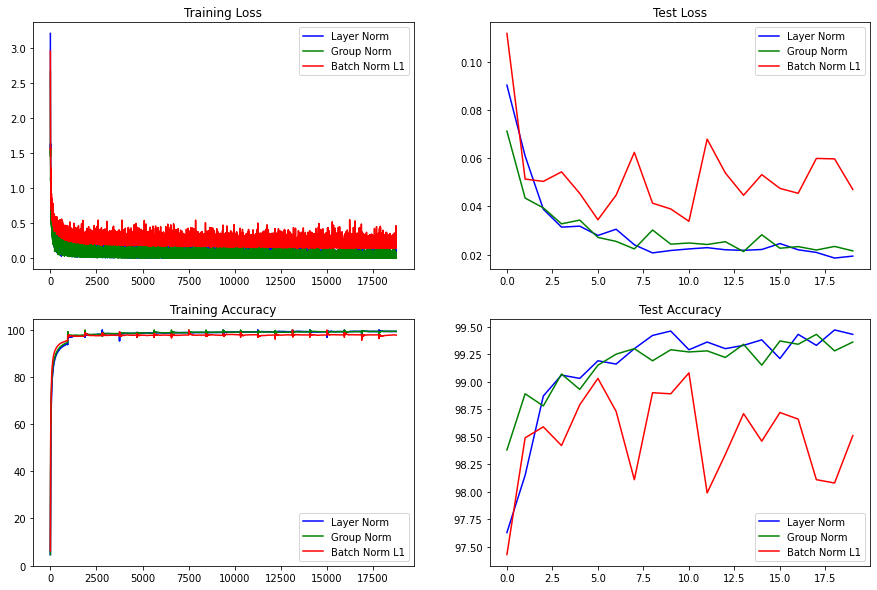

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

train_losses_cpuLN = []
for loss in train_lossesLN:
    train_losses_cpuLN.append(loss.cpu().data.numpy())  
    
train_losses_cpuGN = []
for loss in train_lossesGN:
    train_losses_cpuGN.append(loss.cpu().data.numpy()) 
    
train_losses_cpuBNL1 = []
for loss in train_lossesBNL1:
    train_losses_cpuBNL1.append(loss.cpu().data.numpy()) 

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_cpuLN, color='b', label='Layer Norm')
axs[0, 0].plot(train_losses_cpuGN, color='g', label='Group Norm')
axs[0, 0].plot(train_losses_cpuBNL1, color='r', label='Batch Norm L1')
axs[0, 0].legend(loc="upper right")
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_accLN)
axs[1, 0].plot(train_accLN, color='b', label='Layer Norm')
axs[1, 0].plot(train_accGN, color='g', label='Group Norm')
axs[1, 0].plot(train_accBNL1, color='r', label='Batch Norm L1')
axs[1, 0].legend(loc="lower right")
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_lossesLN, color='b', label='Layer Norm')
axs[0, 1].plot(test_lossesGN, color='g', label='Group Norm')
axs[0, 1].plot(test_lossesBNL1, color='r', label='Batch Norm L1')
axs[0, 1].legend(loc="upper right")
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_accLN, color='b', label='Layer Norm')
axs[1, 1].plot(test_accGN, color='g', label='Group Norm')
axs[1, 1].plot(test_accBNL1, color='r', label='Batch Norm L1')
axs[1, 1].legend(loc="lower right")
axs[1, 1].set_title("Test Accuracy")

fig.savefig('comparison_0.0005.jpg', bbox_inches='tight')
